## **"Build A Better Grinnell" Code Template for 35 each of the issue subset**
> This file includes the **code template** for analyzing each of the issue subset


# A. Setup 



> Run all cells in this section everytime you reload the notebook




In [ ]:
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk import classify
from nltk import NaiveBayesClassifier

import string
import io
from collections import Counter
from google.colab import files
uploaded = files.upload()


Saving formresponses.csv to formresponses (1).csv


In [ ]:
responses = pd.read_csv(io.StringIO(uploaded['formresponses.csv'].decode('iso-8859-1')))
responses.dropna(how='all', inplace = True)

In [ ]:
#downloading required libraries from nltk
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
print(sw_nltk)
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Define the stop words to be removed
stop_words = set(stopwords.words('english'))
#lemmatizing words
lemmatizer = WordNetLemmatizer()

In [ ]:
#function for counting words
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

#function for counting nouns
def noun_str(str):
    noun_list = []
    tokens = nltk.pos_tag(nltk.word_tokenize(str))
    for token in tokens:
        if token[1] == 'NN':
            noun_list.append(token[0])
    finalnounq1 = " ".join(noun_list)
    return finalnounq1

Looking at dataset

In [ ]:
#all columns in dataset - use this to verify column names in the cell below
responses.columns.tolist()

['Random Number',
 'What are things that make you glad to live in Grinnell?  ',
 'What things have the greatest positive impact on your quality of life in Grinnell? ',
 'Tell us about a time when you felt particularly connected to the community or proud to live in Grinnell.',
 'Do you think Grinnell has a set of core values? (e.g. what is important, what we believe, principles guiding our behavior) What do you think they are? ',
 'If you have considered moving from Grinnell, what are reasons you decided to stay?',
 ' If you do not currently live here, what changes in the community might cause you to move to Grinnell?  ',
 'Have there been things that have made you consider leaving Grinnell? What were they?',
 'What things have frustrated you about living in Grinnell?',
 'What things do you think Grinnell is missing \x96 that would benefit you personally if it had?\n ',
 'If funds were unlimited, what changes would you make to improve Grinnell?',
 'If you do not currently live here, wha

In [ ]:
# Identifying columns of interest for exploring issues - use this to verify the indexing below
print(responses.columns.get_loc(" If you do not currently live here, what changes in the community might cause you to move to Grinnell?  "))
print(responses.columns.get_loc("Have there been things that have made you consider leaving Grinnell? What were they?"))
print(responses.columns.get_loc("What things have frustrated you about living in Grinnell?"))
print(responses.columns.get_loc("What things do you think Grinnell is missing \x96 that would benefit you personally if it had?\n "))
print(responses.columns.get_loc("If funds were unlimited, what changes would you make to improve Grinnell?"))
print(responses.columns.get_loc("If you do not currently live here, what changes in the community would make you more likely to move to Grinnell?"))

6
7
8
9
10
11


In [ ]:
# for sentiment analysis
!pip install -q transformers
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
# responses.shape[0]
positive_count = 0
negative_count = 0
neutral_count = 0
x = [0] * 500

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# for clustering

# transform text data into numerical vector
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#Perform k-mean clustering based on the response of input question
#return [dictionary of clusters and its reponse, strings of responses for each cluster]
def clustering(responses, column_id): 
  records = responses.iloc[:, column_id].dropna()

  # extract the text data from the "text" column
  text_data = records.values

  text_data = [" ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text) if word.lower() not in stop_words]) for text in text_data]    

  # transform text data into numerical vector
  vectors = vectorizer.fit_transform(text_data)
  cosine_sim = cosine_similarity(vectors)

  # cluster the data based on cosine similarity
  kmeans = KMeans(n_clusters=5, random_state=0).fit(cosine_sim)

  # Print the cluster labels for each response
  labels = kmeans.labels_

  # create a dictionary to store the responses in each cluster
  k_clusters = {}
  for i, label in enumerate(labels):
      if label not in k_clusters:
          k_clusters[label] = []
      k_clusters[label].append(i)

  #Cluster 
  k_cluster0_response = ''
  for response in k_clusters[0]:
      k_cluster0_response += " " 
      k_cluster0_response += text_data[response]
      
  #Cluster 1
  k_cluster1_response = ''
  for response in k_clusters[1]:
      k_cluster1_response += " " 
      k_cluster1_response += text_data[response]
  
  #k_Cluster 2
  k_cluster2_response = ''
  for response in k_clusters[2]:
      k_cluster2_response += " " 
      k_cluster2_response += text_data[response]

  #k_Cluster 3
  k_cluster3_response = ''
  for response in k_clusters[3]:
      k_cluster3_response += " " 
      k_cluster3_response += text_data[response]

  #k_Cluster 4
  k_cluster4_response = ''
  for response in k_clusters[4]:
      k_cluster4_response += " " 
      k_cluster4_response += text_data[response]

  return k_clusters, k_cluster0_response, k_cluster1_response, k_cluster2_response, k_cluster3_response, k_cluster4_response

# print the responses in each cluster
def print_clusters(k_clusters):
  for label, first in k_clusters.items():
      print(f"Cluster {label}:")
      print(first)
      print()

#Subsetting the cluster based on how the responders answer other question
def subset_clusters (clusters_df, question_id, question_name, graph_limit):
  #Extract responses for question_id
  input = clusters_df.iloc[:,question_id].dropna()
  text_input = input.values

  text_input = [" ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text) if word.lower() not in stop_words]) for text in text_input]    

  text_input = " ". join(text_input)

  nouns = noun_str(text_input)
  nc = word_count(nouns)
  sorted_nouns = sorted(nc.items(), key=lambda x:x[1], reverse=True)
  dict_sorted_nouns = dict(sorted_nouns)
  print(dict_sorted_nouns)

  nouns_result = {key:value for (key, value) in dict_sorted_nouns.items() if value > graph_limit}

  nouns_key = list(nouns_result.keys())
  nouns_counts = list(nouns_result.values())
  #resizing
  fig = plt.figure(figsize=(30, 5))
  plt.bar(range(len(nouns_result)), nouns_counts, tick_label=nouns_key)
  plt.show()

#Counting and plotting bar graphs for most frequently used nouns for each cluster
def clusters_noun (responses, question, graph_limit):
  nouns = noun_str(responses)
  nc = word_count(nouns)
  sorted_nouns  = sorted(nc.items(), key=lambda x:x[1], reverse=True)
  dict_sorted_nouns = dict(sorted_nouns)
  print(dict_sorted_nouns)
  nouns_result = {key:value for (key, value) in dict_sorted_nouns.items() if value >graph_limit}

  nouns_key = list(nouns_result.keys())
  nouns_counts = list(nouns_result.values())
  #resizing
  fig = plt.figure(figsize=(30, 5))
  plt.bar(range(len(nouns_result)), nouns_counts, tick_label=nouns_key)
  plt.title(question)
  plt.show()


def cluster_pie(cluster_dict, cluster_name_list):
  cluster_size_df = pd.DataFrame({"size": [len(cluster_dict[0]), 
                                          len(cluster_dict[1]), 
                                          len(cluster_dict[2]),
                                          len(cluster_dict[3]),
                                          len(cluster_dict[4])],
                                "cluster_name": cluster_name_list
                                })
  pie = cluster_size_df.groupby(['cluster_name']).sum().plot(
    kind='pie', y='size', autopct='%1.0f%%')
  pie.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

# B. Example - Issue: Jobs

>  Replace the keywords in the variable keywords_jobs to run on a different issue

*italicized text*## 1. Creating Subsets

In [ ]:
# need to see which rows out of column index 6,7,8,9,10,11 have the keywords

#This code iterates through each row of the DataFrame and checks whether any of the keywords appear in columns 6, 7, 8, 9, 10, or 11. 
#If a row contains at least one keyword, its index is added to the rows_with_keywords list.

#Note that we concatenate the values in columns 6, 7, 8, 9, and 10 using str(row[6]) + str(row[7]) + str(row[8]) + str(row[9]) + str(row[10]) + str(row[11]) 
# to ensure that we're searching for the keywords across all six columns (the needs questions)

#After running this code, the rows_with_keywords list will contain the indices of all the rows that contain at least one of the specified 
#keywords in columns 6, 7, 8, 9, 10, or 11. 

# CHANGE THIS TO BE DIFFERENT KEYWORDS OF A DIFFERENT ISSUE CATEGORY
keywords_jobs = ['employ', 'employer', 'employment', 'career', 'occupation', 'work', 'profession', 'job', 'recruit', 'recruitment', 'hiring', 'employment opportunity', 'part-time job', 'full-time job', 'temporary job', 'remote work']

rows_with_keywords_jobs = []
for index, row in responses.iterrows():
    if any(keyword in str(row[6]) + str(row[7]) + str(row[8]) + str(row[9]) + str(row[10]) + str(row[11]) for keyword in keywords_jobs):
        rows_with_keywords_jobs.append(index)
#NOTE THIS IS THE RESPONDENT NUMBER - 1. Its the actual row in the data.
print(rows_with_keywords_jobs)

# create a new DataFrame with only the rows that contain the specified keywords
selected_rows_jobs = responses.iloc[rows_with_keywords_jobs, :]

# export the selected rows to an Excel file
selected_rows_jobs.to_excel("selected_rows_jobs.xlsx", index=False)

[2, 3, 4, 7, 8, 10, 17, 19, 20, 21, 24, 25, 26, 30, 31, 33, 34, 35, 41, 44, 46, 54, 56, 61, 63, 70, 72, 78, 82, 86, 89, 91, 95, 102, 108, 118, 130, 132, 134, 143, 151, 158, 159, 167, 171, 176, 178, 181, 182, 183, 184, 188, 192, 193, 196, 197, 200, 202, 203, 204, 208, 213, 220, 222, 230, 233, 242, 244, 247, 249, 251, 252, 253, 255, 264, 266, 270, 275, 280, 285, 286, 290, 291, 295, 297, 298, 310, 314, 316, 320, 323, 327, 337, 344, 346, 349, 359, 371, 373, 384, 385, 389, 392, 393, 398, 401, 404, 406, 414, 416, 422, 425, 426, 427, 428, 429, 439, 442, 446, 447, 449, 450, 451, 454, 457, 458, 459, 467, 470, 486, 490, 492, 495, 496, 503, 507, 510, 515, 516, 520, 526, 534, 537, 538, 539]


## 2. Sentimental Analysis

In [ ]:
import pandas as pd
import numpy as np 

# Assuming we have the number of questions and respondents:
# Done on the columns 2-11
num_questions = 11
num_respondents = selected_rows_jobs.shape[0]

# Initialize an empty matrix with the same dimensions as the number of respondents and questions
sentiment_matrix = np.zeros((num_respondents, num_questions))

# Iterate through each question and respondent
for question_index in range(num_questions):
    for respondent_index in range(num_respondents):
        # Assuming selected_rows_jobs is a DataFrame with one column per question
        if question_index == 10:
            response = selected_rows_jobs.iloc[respondent_index][question_index]
            if isinstance(response, str):
                response = response[:512] #limit the character count to avoid system overload
            else:
                response = str(response)
        else:
            response = selected_rows_jobs.iloc[respondent_index, question_index]
        if isinstance(response, str):
            #temp = sentiment_pipeline(selected_rows_jobs.iloc[i][10][:512])[0]
            temp = sentiment_pipeline(response)[0]
            label = temp['label']
            score = temp['score']
            # Adding score for each cell, if the sentiment score <=0, then the cell will consider as neutral.
            if score <= 0.95:
                sentiment_score = 0 
            elif label == 'POSITIVE':
                sentiment_score = score
            elif label == 'NEGATIVE':
                sentiment_score = -1 * score
            # Store the sentiment score in the matrix
            sentiment_matrix[respondent_index, question_index] = sentiment_score

# Convert the matrix to a Pandas DataFrame
sentiment_df = pd.DataFrame(sentiment_matrix, columns=[f'Question {i+1}' for i in range(num_questions)])

# Sentiment_df provides matrix with all the sentiment scores for each response for every question in the survey.
print(sentiment_df)

     Question 1  Question 2  Question 3  Question 4  Question 5  Question 6  \
0      0.991803    0.999773    0.983198    0.992463    0.998630    0.993714   
1      0.986155    0.000000    0.000000    0.000000    0.000000    0.000000   
2      0.989470    0.998318    0.999009    0.997646    0.999848   -0.998869   
3      0.976206    0.999397    0.999836    0.996948   -0.995692    0.999260   
4      0.980660    0.992002    0.999710    0.995302    0.000000    0.000000   
..          ...         ...         ...         ...         ...         ...   
140    0.000000    0.999858    0.983409    0.000000    0.999143   -0.991866   
141    0.000000    0.974057    0.999111    0.998280   -0.997922    0.999734   
142    0.000000    0.000000   -0.966932   -0.997596    0.994959   -0.996446   
143    0.000000   -0.997323    0.000000    0.000000   -0.962013   -0.991437   
144    0.000000    0.999865    0.999781    0.998495    0.000000    0.000000   

     Question 7  Question 8  Question 9  Question 1

In [ ]:
import pandas as pd

# Calculate the average sentiment score for each respondent
sentiment_rate = sentiment_df.mean(axis=1)

# Create a new DataFrame with "Random Number" and sentiment rate columns
# average_sentiment_df = pd.DataFrame({
#     'Resondent Number': selected_rows_jobs['Random Number'],
#     'Average Sentiment Rate': sentiment_rate
# })

average_sentiment_df = pd.DataFrame({
    'Respondent Number': selected_rows_jobs['Random Number'].fillna(method='ffill'),
    'Average Sentiment Rate': sentiment_rate
})

# Export the DataFrame to an Excel file
average_sentiment_df.to_excel('average_sentiment_jobs.xlsx', index=False)


## What are the respondents of this issue category saying for Q1-5?

In [ ]:
# combining responses of positive questions 1:6 columns
import pandas as pd

# Assume your data frame is named "selected_rows_jobs"
# Combine columns 1 to 6 into a single column named "combined_responses"
selected_rows_jobs['combined_responses'] = selected_rows_jobs.iloc[:, 1:6].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

<ipython-input-69-f331a39f686c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows_jobs['combined_responses'] = selected_rows_jobs.iloc[:, 1:6].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [ ]:
import string
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download the stopwords from nltk
nltk.download('stopwords')
nltk.download('words')

# Define the column of string-type records
records = selected_rows_jobs['combined_responses'].dropna()


# Define the vocabulary of correctly spelled words
vocab = set(words.words())

# Initialize an empty Counter object
word_counts = Counter()

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Loop over each record in the column
for record in records:
    # Split the record into individual words and remove punctuation
    words = word_tokenize(record.lower().translate(str.maketrans('', '', string.punctuation)))
    
    # Remove stop words from the list of words
    words = [word for word in words if word not in stop_words]
    
    # Spell check each word and replace any misspelled words with the original word
    words = [word if word in vocab else word.lower() for word in words]
    
    #lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]

    # Count the number of occurrences of each word in the record
    record_word_counts = Counter(set(words))
    
    # Add the record's word counts to the overall word count
    word_counts += record_word_counts

# Print the final word count dictionary
print(word_counts)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Counter({'community': 100, 'grinnell': 73, 'people': 71, 'town': 68, 'college': 65, 'small': 53, 'school': 52, 'family': 50, 'park': 41, 'value': 41, 'job': 39, 'friend': 38, 'good': 36, 'think': 35, 'business': 34, 'event': 33, 'core': 32, 'city': 32, 'like': 31, 'work': 30, 'live': 30, 'feel': 29, 'opportunity': 27, 'year': 25, 'downtown': 25, 'great': 25, 'many': 24, 'safe': 24, 'together': 24, 'care': 23, 'local': 23, 'thing': 23, 'know': 23, 'support': 22, 'make': 22, 'easy': 22, 'get': 22, 'group': 21, 'activity': 21, 'really': 21, 'restaurant': 20, 'want': 20, 'need': 20, 'size': 19, 'library': 19, 'also': 19, 'place': 18, 'art': 18, 'nice': 18, 'music': 18, 'friendly': 18, 'around': 18, 'church': 18, 'quality': 17, 'time': 17, 'neighbor': 17, 'life': 17, 'moving': 17, 'dont': 17, 'move': 16, 'area': 16, 'everyone': 16, 'different': 16, 'connected': 16, 'living': 15, 'lot': 15, 'would': 15, 'derecho': 15, 'yes': 15, 'access': 15, 'kid': 15, 'close': 15, 'iowa': 14, 'education': 

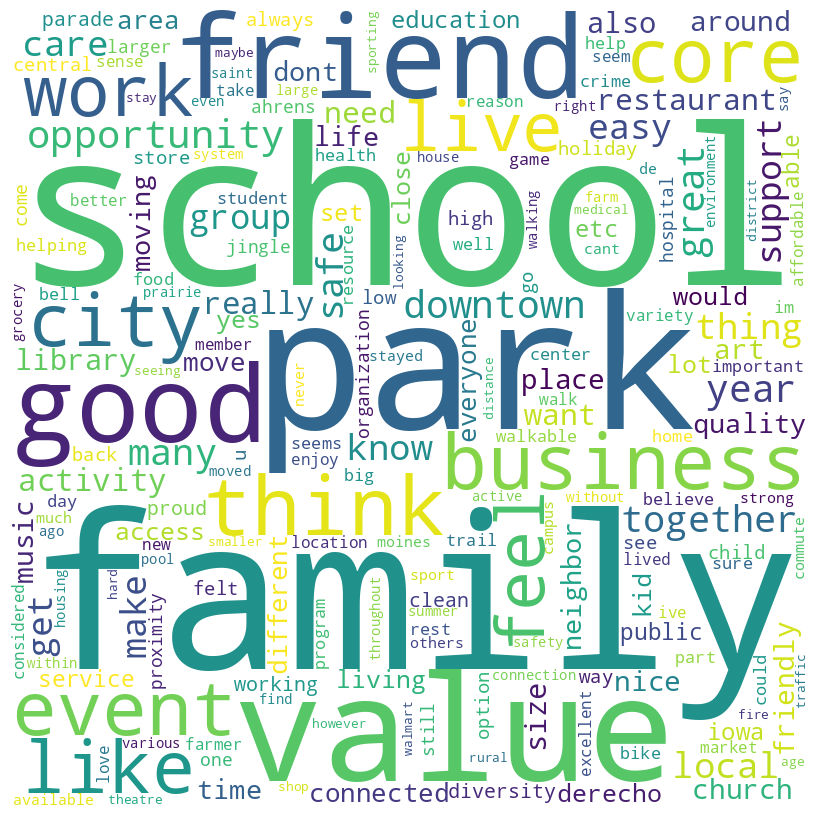

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Remove the words from the word count list
words_to_remove = ['community', 'town', 'small', 'people', 'college', 'grinnell','job']
for word in words_to_remove:
    word_counts.pop(word)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


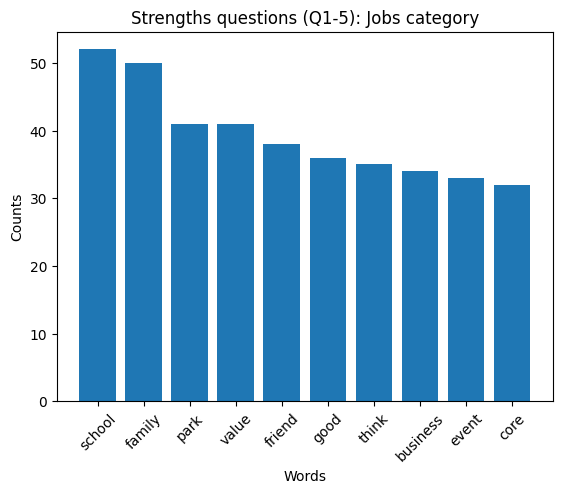

In [ ]:
import matplotlib.pyplot as plt

# Words to exclude from the word count list
excluded_words = {'community', 'town', 'small', 'people', 'college', 'grinnell', 'job'}

# Get the top 10 words and their counts, excluding the excluded words
top_words = [(word, count) for word, count in word_counts.most_common(10)
             if word not in excluded_words]

# Unpack the top words and their counts into separate lists
words, counts = zip(*top_words)

# Create a bar plot of the top words and their counts
plt.bar(words, counts)
plt.title('Strengths questions (Q1-5): Jobs category')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)

plt.show()


## 3. Clutering using question 2

In [ ]:
##To perform the clustering, call the clustering function on the dataframe identified and the number representing the question to be used.
# You can change the variable name (for example: cluster_job_q2 to cluster_housing_q1)
# the function return the dictionary of responses in each cluster and strings for all the responses in each cluster
cluster_job_q2 = clustering(selected_rows_jobs, 2)

# We can print the dictionary showing the response belonging to each cluster
print_clusters(cluster_job_q2[0])

#each clusters_noun() call will give you the bar chart for the noun count of each cluster.
# The string is for the title of the graph 
# You can also change the threshold for the count of words neededfrom 1 to a number of your choice.
clusters_noun(cluster_job_q2[1], "What things have the greatest positive impact on your quality of life in Grinnell? ",  1)
clusters_noun(cluster_job_q2[2], "What things have the greatest positive impact on your quality of life in Grinnell? ",  1)
clusters_noun(cluster_job_q2[3], "What things have the greatest positive impact on your quality of life in Grinnell? ",  1)
clusters_noun(cluster_job_q2[4], "What things have the greatest positive impact on your quality of life in Grinnell? ",  1)
clusters_noun(cluster_job_q2[5], "What things have the greatest positive impact on your quality of life in Grinnell? ",  1)


In [ ]:
#from the bar charts of the count of nouns in each cluster and manually going through the responses of each cluster,
#we can identify the label. Insert them in the array for cluster name in the order of 1-5
jobs_q2_cluster_name = ["activities for family","jobs/opportunity", "undefined","community/church", "park"]

#In order to create the pie chart, call cluster_pie function with the appropiate cluster dictionary and cluster name array
cluster_pie(cluster_job_q2[0], jobs_q2_cluster_name)